In [9]:
import pandas as pd
from collections import Counter
import sys
sys.path.append('../speech-accent-recognition/src>')
#import importlib
#importlib.__import__(getsplit)
import getsplit
import matplotlib.pyplot as plt

from keras import utils
import accuracy
import multiprocessing
import librosa, librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, TensorBoard



In [38]:

DEBUG = True
SILENCE_THRESHOLD = .01
RATE = 24000
N_MFCC = 13
COL_SIZE = 30
EPOCHS = 10 #35#250

def to_categorical(y):
    '''
    Converts list of languages into a binary class matrix
    :param y (list): list of languages
    :return (numpy array): binary class matrix
    '''
    lang_dict = {}
    for index,language in enumerate(set(y)):
        lang_dict[language] = index
    y = list(map(lambda x: lang_dict[x],y))
    return utils.to_categorical(y, len(lang_dict))
'''
#Originals
def get_wav(language_num):
    '''
    Load wav file from disk and down-samples to RATE
    :param language_num (list): list of file names
    :return (numpy array): Down-sampled wav file
    '''

    y, sr = librosa.load('../audio/{}.wav'.format(language_num))
    return(librosa.core.resample(y=y,orig_sr=sr,target_sr=RATE, scale=True))

def to_mfcc(wav):
    '''
    Converts wav file to Mel Frequency Ceptral Coefficients
    :param wav (numpy array): Wav form
    :return (2d numpy array: MFCC
    '''
    return(librosa.feature.mfcc(y=wav, sr=RATE, n_mfcc=N_MFCC))
'''
def to_mfcc(wavs):
    '''
    Converts wav file to Mel Frequency Ceptral Coefficients
    :param wav (numpy array): Wav form
    :return (2d numpy array: MFCC
    '''
    pathAudio = "/Audio/"
    files = librosa.util.find_files(pathAudio, ext=['ogg']) 
    print(len(files))
    files = np.asarray(files)
    for y in files: 
        y = librosa.load(y, sr = 16000,mono = True)
        print("done")
        librosa.display.waveplot(y)
    
    print(wavs)
    x_train = np.array(len(wavs))
    for wav in wavs:
        #y, sr = librosa.load('~/audio/{}.wav'.format(wav))
        
        
        MFCCs = librosa.feature.mfcc(signal, sr=RATE, n_mfcc=N_MFCC)
        np.append(x_train, MFCCs)
    #print(x_train)
    return x_train

def remove_silence(wav, thresh=0.04, chunk=5000):
    '''
    Searches wav form for segments of silence. If wav form values are lower than 'thresh' for 'chunk' samples, the values will be removed
    :param wav (np array): Wav array to be filtered
    :return (np array): Wav array with silence removed
    '''

    tf_list = []
    for x in range(len(wav) / chunk):
        if (np.any(wav[chunk * x:chunk * (x + 1)] >= thresh) or np.any(wav[chunk * x:chunk * (x + 1)] <= -thresh)):
            tf_list.extend([True] * chunk)
        else:
            tf_list.extend([False] * chunk)

    tf_list.extend((len(wav) - len(tf_list)) * [False])
    return(wav[tf_list])

def normalize_mfcc(mfcc):
    '''
    Normalize mfcc
    :param mfcc:
    :return:
    '''
    mms = MinMaxScaler()
    return(mms.fit_transform(np.abs(mfcc)))

def make_segments(mfccs,labels):
    '''
    Makes segments of mfccs and attaches them to the labels
    :param mfccs: list of mfccs
    :param labels: list of labels
    :return (tuple): Segments with labels
    '''
    segments = []
    seg_labels = []
    for mfcc,label in zip(mfccs,labels):
        for start in range(0, int(mfcc.shape[1] / COL_SIZE)):
            segments.append(mfcc[:, start * COL_SIZE:(start + 1) * COL_SIZE])
            seg_labels.append(label)
    return(segments, seg_labels)

def segment_one(mfcc):
    '''
    Creates segments from on mfcc image. If last segments is not long enough to be length of columns divided by COL_SIZE
    :param mfcc (numpy array): MFCC array
    :return (numpy array): Segmented MFCC array
    '''
    segments = []
    for start in range(0, int(mfcc.shape[1] / COL_SIZE)):
        segments.append(mfcc[:, start * COL_SIZE:(start + 1) * COL_SIZE])
    return(np.array(segments))

def create_segmented_mfccs(X_train):
    '''
    Creates segmented MFCCs from X_train
    :param X_train: list of MFCCs
    :return: segmented mfccs
    '''
    segmented_mfccs = []
    for mfcc in X_train:
        segmented_mfccs.append(segment_one(mfcc))
    return(segmented_mfccs)


def train_model(X_train,y_train,X_validation,y_validation, batch_size=128): #64
    '''
    Trains 2D convolutional neural network
    :param X_train: Numpy array of mfccs
    :param y_train: Binary matrix based on labels
    :return: Trained model
    '''

    # Get row, column, and class sizes
    rows = X_train[0].shape[0]
    cols = X_train[0].shape[1]
    val_rows = X_validation[0].shape[0]
    val_cols = X_validation[0].shape[1]
    num_classes = len(y_train[0])

    # input image dimensions to feed into 2D ConvNet Input layer
    input_shape = (rows, cols, 1)
    X_train = X_train.reshape(X_train.shape[0], rows, cols, 1 )
    X_validation = X_validation.reshape(X_validation.shape[0],val_rows,val_cols,1)


    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'training samples')

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3,3), activation='relu',
                     data_format="channels_last",
                     input_shape=input_shape))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    # Stops training if accuracy does not change at least 0.005 over 10 epochs
    es = EarlyStopping(monitor='acc', min_delta=.005, patience=10, verbose=1, mode='auto')

    # Creates log file for graphical interpretation using TensorBoard
    tb = TensorBoard(log_dir='../logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True,
                     write_images=True, embeddings_freq=0, embeddings_layer_names=None,
                     embeddings_metadata=None)

    # Image shifting
    datagen = ImageDataGenerator(width_shift_range=0.05)

    # Fit model using ImageDataGenerator
    model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=len(X_train) / 32
                        , epochs=EPOCHS,
                        callbacks=[es,tb], validation_data=(X_validation,y_validation))

    return (model)

def save_model(model, model_filename):
    '''
    Save model to file
    :param model: Trained model to be saved
    :param model_filename: Filename
    :return: None
    '''
    model.save('../models/{}.h5'.format(model_filename))  # creates a HDF5 file 'my_model.h5'



############################################################




#######################################

if __name__ == '__main__':
    '''
        Console command example:
        python trainmodel.py bio_metadata.csv model50
        '''

    # Load arguments
    # print(sys.argv)
    file_name = 'data_afr_azer_dan.csv'
    model_filename = 'model1.h5'

    # Load metadata
    df = pd.read_csv(file_name)


    # Filter metadata to retrieve only files desired
    filtered_df = getsplit.filter_df(df)

    # filtered_df = filter_df(df)

    # print(filtered_df)

    # print("filterd df is empty {}".format(filtered_df))

    # Train test split
    X_train, X_test, y_train, y_test = getsplit.split_people(filtered_df)

    # Get statistics
    train_count = Counter(y_train)
    test_count = Counter(y_test)

    print("Entering main")

    # import ipdb;
    # ipdb.set_trace()


    acc_to_beat = test_count.most_common(1)[0][1] / float(np.sum(list(test_count.values())))

    # To categorical
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Get resampled wav files using multiprocessing
    '''
     # Get resampled wav files using multiprocessing
    if DEBUG:
        print('Loading wav files....')
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    X_train = pool.map(get_wav, X_train)
    X_test = pool.map(get_wav, X_test)

    # Convert to MFCC
    if DEBUG:
        print('Converting to MFCC....')
    X_train = pool.map(to_mfcc, X_train)
    X_test = pool.map(to_mfcc, X_test)
    '''

    # Convert to MFCC
    if DEBUG:
        print('Converting to MFCC....')
    X_train = to_mfcc(X_train)
    X_test = to_mfcc(X_test)

    # Create segments from MFCCs
    X_train, y_train = make_segments(X_train, y_train)
    X_validation, y_validation = make_segments(X_test, y_test)

    # Randomize training segments
    X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0)

    # Train model
    model = train_model(np.array(X_train), np.array(y_train), np.array(X_validation),np.array(y_validation))

    # Make predictions on full X_test MFCCs
    y_predicted = accuracy.predict_class_all(create_segmented_mfccs(X_test), model)

    # Print statistics
    print('Training samples:', train_count)
    print('Testing samples:', test_count)
    print('Accuracy to beat:', acc_to_beat)
    print('Confusion matrix of total samples:\n', np.sum(accuracy.confusion_matrix(y_predicted, y_test),axis=1))
    print('Confusion matrix:\n',accuracy.confusion_matrix(y_predicted, y_test))
    print('Accuracy:', accuracy.get_accuracy(y_predicted,y_test))

    # Save model
    save_model(model, model_filename)

Entering main
Converting to MFCC....
0
14         danish4
5       afrikaans6
4       afrikaans5
0       afrikaans1
8     azerbaijani3
18         danish8
17         danish7
11         danish1
10    azerbaijani5
9     azerbaijani4
7     azerbaijani2
1       afrikaans2
19         danish9
12         danish2
6     azerbaijani1
15         danish5
Name: language_num, dtype: object
0
3     afrikaans4
13       danish3
2     afrikaans3
16       danish6
Name: language_num, dtype: object


TypeError: iteration over a 0-d array

In [ ]:
X_train[0] = pool.map(get_wav, X_train[0])

In [3]:
X_train[0]

'afrikaans1'

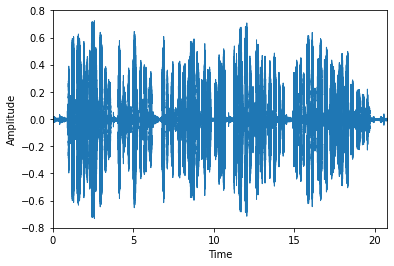

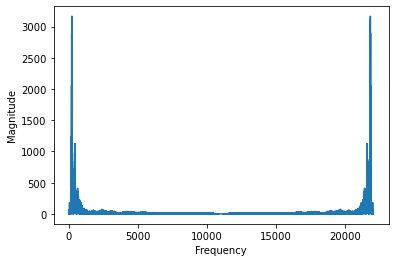

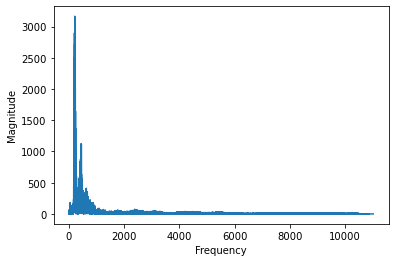

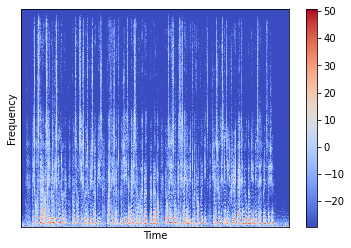

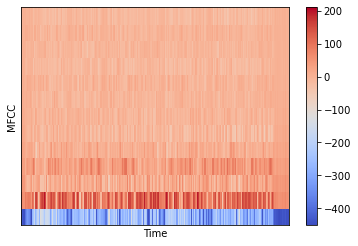

In [24]:
file = "audio/afrikaans1.wav"

signal, sr = librosa.load(file, sr=22050) #find out why this happens

librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

#stft "spectrogram"
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()


#MFCC
MFCCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()